# Import packages and modules

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from time import time

%matplotlib inline

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Useful Functions

In [ ]:
## accuracy, precision, recall, f1 score

def apr(y_pred, y_real):
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


## confusion matrix

def produce_confusion(positive_label, negative_label, cut_off, df, y_pred_name, y_real_name):
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(df[y_real_name], df['pred_binary']))
    print('Test precision = ', precision_score(df[y_real_name], df['pred_binary']))
    print('Test recall = ', recall_score(df[y_real_name], df['pred_binary']))
    print('Test f1 = ', f1_score(df[y_real_name], df['pred_binary']))


    return accuracy_score(df[y_real_name], df['pred_binary'])

In [ ]:
#import data from csv to DataFrame
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

# Feature Engineering

In [ ]:
#function to automatically create dummies to chosen columns
def one_hot(df, col):
    new_df = pd.get_dummies(df, columns=col, prefix=col[0])
    return new_df

#main feature engineering function
def feature_eng(dfx):

    dfx = dfx.copy()

    dfx['Total Charges'] = dfx['Total Charges'].apply(pd.to_numeric, errors = 'coerce')
    dfx['Total Charges'].fillna(0, inplace = True)

    
    to_be_dummied = [
                    'Gender',
                    'Senior Citizen', 
                    'Partner', 
                    'Dependents',
                    'Phone Service',
                    'Multiple Lines', 
                    'Internet Service', 
                    'Online Security', 
                    'Online Backup', 
                    'Device Protection', 
                    'Tech Support', 
                    'Streaming TV', 
                    'Streaming Movies', 
                    'Contract', 
                    'Paperless Billing', 
                    'Payment Method'
                     ]

    feature_cols = list(dfx.columns)
    
    one_hot_targets = []
    not_hot_cols = []

    for i in feature_cols:
        if i in to_be_dummied:
            one_hot_targets.append(i)
        else:
            not_hot_cols.append(i)


    for target in one_hot_targets:
        new = one_hot(dfx[target], [target])
        dfx.drop(columns=target, inplace=True)
        feature_cols.remove(target)
        new_list = feature_cols + list(new.columns)
        feature_cols = new_list.copy()
        dfx = pd.concat([dfx, new], axis=1, join="inner")

    dfx['Payment Method_Automatic'] = dfx['Payment Method_Bank transfer (automatic)'] + dfx['Payment Method_Credit card (automatic)']
    dfx['Payment Method_Manual'] = dfx['Payment Method_Electronic check'] + dfx['Payment Method_Mailed check']


    final_cols = [  
                    'Monthly Charges', 
                    #'Total Charges', 
                    'Tenure Months', 
                    #'Churn Value',
                    #'Gender_Female', 
                    #'Gender_Male', 
                    #'Senior Citizen_No',
                    #'Senior Citizen_Yes', 
                    #'Partner_No', 
                    #'Partner_Yes', 
                    #'Dependents_No',
                    'Dependents_Yes', 
                    #'Phone Service_No', 
                    #'Phone Service_Yes',
                    #'Multiple Lines_No', 
                    #'Multiple Lines_No phone service',   
                    #'Multiple Lines_Yes', 
                    #'Internet Service_DSL',
                    'Internet Service_Fiber optic', 
                    #'Internet Service_No',
                    #'Online Security_No', 
                    #'Online Security_No internet service',
                    #'Online Security_Yes', 
                    #'Online Backup_No',
                    #'Online Backup_No internet service', 
                    #'Online Backup_Yes',
                    #'Device Protection_No', 
                    #'Device Protection_No internet service',
                    #'Device Protection_Yes', 
                    #'Tech Support_No',
                    #'Tech Support_No internet service', 
                    #'Tech Support_Yes',
                    #'Streaming TV_No',
                    #'Streaming TV_No internet service',
                    #'Streaming TV_Yes', 
                    #'Streaming Movies_No',
                    #'Streaming Movies_No internet service', 
                    #'Streaming Movies_Yes',
                    'Contract_Month-to-month', 
                    #'Contract_One year',
                    #'Contract_Two year',
                    #'Paperless Billing_No', 
                    'Paperless Billing_Yes',
                    #'Payment Method_Bank transfer (automatic)',
                    #'Payment Method_Credit card (automatic)',
                    #'Payment Method_Electronic check', 
                    #'Payment Method_Mailed check',
                    #'Payment Method_Automatic',
                    #'Payment Method_Manual'
                    ]

    for col in final_cols: 
        if col not in dfx.columns:
            dfx[col] = 0

    dfx = dfx[final_cols]
        
    return dfx

In [ ]:
#applying feature engineering
X_train_eng = feature_eng(X_train)
X_test_eng = feature_eng(X_test)

In [ ]:
# define feature cols
feature_cols = list(X_train_eng.columns)

# Decision Tree

In [ ]:
# create empty classifier
treeclf = DecisionTreeClassifier(max_depth=5)

In [ ]:
# X are predictors, y is list of classes
X = X_train_eng[feature_cols]
y = y_train['Churn Value']

# fit the model
our_model = treeclf.fit(X, y)

In [ ]:
# see the output classes
treeclf.classes_

array([0, 1])

In [ ]:
# create treeplot
#fig = plt.figure(figsize=(50,40))

# the underscore is needed to give a 'name' to the treeplot
#_ = tree.plot_tree(treeclf, feature_names = feature_cols, class_names = ['Did Not Churn', 'Churned'], filled = True)

In [ ]:
# tree scores
print(f'Score on training set: {treeclf.score(X_train_eng[feature_cols], y_train)}')
print(f'Score on testing set: {treeclf.score(X_test_eng[feature_cols], y_test)}')

Score on training set: 0.7998864066641423
Score on testing set: 0.7864849517319704


# GridSearch

In [ ]:
# gridsearch of many trees

grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
                                  'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100, 200],
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 10, 20, 50]},
                    cv = 5,
                    refit = True,
                    verbose = 1,
                    scoring = 'accuracy')

In [ ]:
# fitting all combinations of parameters

now = time()

grid.fit(X_train_eng, y_train)

print(f' Time in seconds: {time() - now}')

Fitting 5 folds for each of 1287 candidates, totalling 6435 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 Time in seconds: 58.296223640441895


[Parallel(n_jobs=1)]: Done 6435 out of 6435 | elapsed:   58.3s finished


In [ ]:
# best parameters for decision tree 
grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 200}

In [ ]:
# accuracy score
grid.best_score_

0.7996957512685989

In [ ]:
# best model to run
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
#defining parameters
dt = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20, min_samples_split=200)

In [ ]:
# fitting model
dt.fit(X_train_eng, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# create treeplot
#fig = plt.figure(figsize=(50,40))

# the underscore is needed to give a 'name' to the treeplot
#_ = tree.plot_tree(dt, feature_names = feature_cols, class_names = ['Did Not Churn', 'Churned'], filled = True)

In [ ]:
#train predictions
train_results = X_train_eng.copy()
train_results['y_pred'] = dt.predict(X_train_eng)
train_results['y_real'] = y_train
train_results['y_prob'] = dt.predict_proba(X_train_eng)[:,1]

In [ ]:
#test predictions
test_results = X_test_eng.copy()
test_results['y_pred'] = dt.predict(X_test_eng)
test_results['y_real'] = y_test
test_results['y_prob'] = dt.predict_proba(X_test_eng)[:,1]

# Feature Importance

In [ ]:
# feature importance
importance = list(zip(feature_cols, list(dt.feature_importances_)))

In [ ]:
#sorted list of importances
sorted(importance, key = lambda x: x[1], reverse= True)

[('Contract_Month-to-month', 0.47401237214605507),
 ('Tenure Months', 0.20903857826651445),
 ('Internet Service_Fiber optic', 0.149604322327802),
 ('Monthly Charges', 0.0792506630651743),
 ('Dependents_Yes', 0.07315136565284057),
 ('Paperless Billing_Yes', 0.014942698541613631)]

# Metrics

Test accuracy =  0.8118137069291935
Test precision =  0.6732673267326733
Test recall =  0.542422044960116
Test f1 =  0.6008032128514057


0.8118137069291935

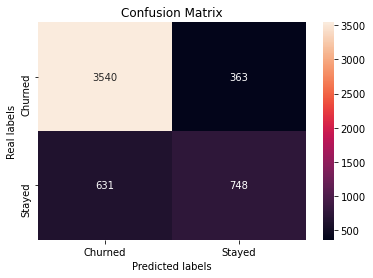

In [ ]:
# confision matrix for train data
produce_confusion('Stayed', 'Churned', 'binary', train_results, 'y_pred', 'y_real')

Test accuracy =  0.8063600227143668
Test precision =  0.6778042959427207
Test recall =  0.5795918367346938
Test f1 =  0.6248624862486248


0.8063600227143668

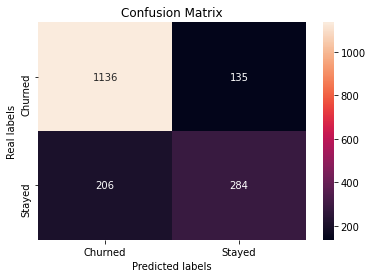

In [ ]:
#confusion matrix for test data
produce_confusion('Stayed', 'Churned', 'binary', test_results, 'y_pred', 'y_real')

# Churn risk list

In [ ]:
#importing original data into dataframe
myDF = pd.read_excel('customer_churn.xlsx', header = 0)

In [ ]:
churn = myDF.copy()
#removing useless columns
try:
    churn.drop(columns = ['Churn Label','CustomerID', 'Count', 'Country', 'State','City','Lat Long', 'Latitude', 'Longitude', 'Churn Reason'], inplace = True)
except:
    print('Already dropped!')

In [ ]:
#only existing customers
loyal = churn[churn['Churn Value'] == 0]
loyal_eng = feature_eng(loyal)

loyal_eng

,Monthly Charges,Tenure Months,Dependents_Yes,Internet Service_Fiber optic,Contract_Month-to-month,Paperless Billing_Yes
1869,29.85,1,0,0,1,1
1870,56.95,34,0,0,0,0
1871,42.30,45,0,0,0,0
1872,89.10,22,1,1,1,1
1873,29.75,10,0,0,1,0
...,...,...,...,...,...,...
7038,21.15,72,0,0,0,1
7039,84.80,24,1,0,0,1
7040,103.20,72,1,1,0,1
7041,29.60,11,1,0,1,1


In [ ]:
#adding Customer ID back to the dataframe
loyal_id = myDF['CustomerID'][myDF['Churn Value'] == 0]
test = loyal_eng.join(loyal_id)
test.sort_values('Churn Probability', ascending= False, inplace = True)

In [ ]:
#list of top 500 by churn risk
churn_list = test[['CustomerID', 'Churn Probability']].head(500)
churn_list

,CustomerID,Churn Probability
4327,5043-TRZWM,0.869822
2948,1866-OBPNR,0.869822
5820,4273-MBHYA,0.869822
5786,1941-HOSAM,0.869822
4329,1640-PLFMP,0.869822
...,...,...
4460,2916-BQZLN,0.538043
5443,9058-MJLZC,0.538043
3330,5692-ICXLW,0.538043
6676,3439-GVUSX,0.483871


In [ ]:
# save list as csv file
churn_list.to_csv('DT_top_500.csv', index = None)